<h1 style='color:orange; font-weight:bold; text-align:center'>Latent Dirichlet Allocation</h1>

In [30]:
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from collections import Counter
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import warnings

plt.style.use('ggplot')
pd.options.display.max_colwidth=50
warnings.filterwarnings("ignore", category=DeprecationWarning)

## **4 Topic Modeling**
Previously, I already performed text analysis on the user reviews with raw frequencies approach. Using this approach, most frequent words or word combinations could be identified to investigate \<\<RESULT>>. While its usefulness to reveal the insights, it is important to note that this approach does not take relationship between words into account. This approach consideers words or word combinations in isolation. This approach, therefore, cannot capture key themes since themes or topics are identified based on co-texts or the relationship between words. Topic modeling, however, considers words in their co-texts, revealing insights into the main themes. Topics here identified by a distribution of words frequenty co-occur.

### **4.1 Data Preparation**

In [ ]:
# load the dataset
df4 = pd.read_csv('../data/review_gopay_newest_sort.csv')

In [22]:
# prepare stopwords
# nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))
custom_stopwords = {'yang', 'aja', 'yg', 'nya', 'sih', 'oh', 'e', 'deh'}
stop_words.update(custom_stopwords)

# preprocess function
def tokenize_text(text):
    if isinstance(text, str):                                           # check if the input is a string
        text = text.lower()                                             # convert to lowercase
        text = re.sub(r'\d+', '__num__', text)                          # remove numbers
        text = re.sub(r'\W+', ' ', text)                                # remove punctuation
        text = re.sub(r'http\S+|www\S+', '__url__', text)               # remove URLs
        tokens = text.split()                                           # split into tokens
        tokens = [word for word in tokens if word not in stop_words]    # remove stopwords
        return tokens
    return []                                                           # if not string, return an empty list

# apply preprocessing
df4['tokens'] = df4['content'].apply(tokenize_text)

### **4.1 Brief Introduction to LDA**
**Note**: Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

### **4.2 Grid Search of Ideal Topic Number**

Similar to *k*-mean clustering, topic modeling using Latent Dirichlet Allocation also needs one of the parameter to be specified. One way to determine the optimal number of topics is with perplexity score or coherence score. Perplexity focuses more on the topic model's statistical performance and prediction ability whereas coherence score is concerned more with the human interpretability of the topics. For optimizing interpretability to stakeholders, coherence score is utilized to find out the optimal topic number. Given the output value ranging between 0 and 1, the ideal result is the highest coherence score as possible. In addition to the metric, the method to obtain the ideal number of topic is grid search. This method searches every possible combination of parameters based on a specific metric. In this context, grid search will search the highest coherence score as possible with all topic numbers. 

Reference: [Coherence score](https://radimrehurek.com/gensim/models/coherencemodel.html)

In [23]:
# create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df4['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df4['tokens'] if tokens]  # filter out empty lists

In [24]:
# search for optimal number of topics
topics_range = range(2, 11)
coherence_scores = []
timing_info = []

for num_topics in topics_range:
    start_time = time.time()
    # train the LDA model
    print(f'Training model with {num_topics} topics...')
    lda_model = LdaModel(corpus=corpus,
                         num_topics=num_topics,
                         id2word=dictionary,
                         passes=20,
                         random_state=42)
    # compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=df4['tokens'],
                                    dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

    end_time = time.time()
    elapsed_time = end_time - start_time
    timing_info.append(elapsed_time)
    print(f'> Num of topics: {num_topics}, coherence score: {coherence_score:.4f}, training time: {elapsed_time:.2f} seconds')

Training model with 2 topics...
> Num of topics: 2, coherence score: 0.4995, training time: 89.86 seconds
Training model with 3 topics...
> Num of topics: 3, coherence score: 0.5186, training time: 98.95 seconds
Training model with 4 topics...
> Num of topics: 4, coherence score: 0.5309, training time: 95.96 seconds
Training model with 5 topics...
> Num of topics: 5, coherence score: 0.5503, training time: 97.58 seconds
Training model with 6 topics...
> Num of topics: 6, coherence score: 0.5342, training time: 100.24 seconds
Training model with 7 topics...
> Num of topics: 7, coherence score: 0.5215, training time: 101.67 seconds
Training model with 8 topics...
> Num of topics: 8, coherence score: 0.4851, training time: 96.36 seconds
Training model with 9 topics...
> Num of topics: 9, coherence score: 0.5026, training time: 95.58 seconds
Training model with 10 topics...
> Num of topics: 10, coherence score: 0.5016, training time: 95.12 seconds


In [25]:
# choose the optimal number of topics based on the highest coherence score
mean_cs = np.mean(coherence_scores)
sd_cs = np.std(coherence_scores)
mean_tt = round(np.mean(timing_info), 2)
sd_tt = round(np.std(timing_info), 2)
optimal_num_topics = topics_range[np.argmax(coherence_scores)]

print(f'Mean of coherence scores: {mean_cs:.4f} ± {sd_cs:.4f}')
print(f'Mean of training time: {mean_tt} seconds ± {sd_tt} seconds')
print(f'Optimal Number of Topics: {optimal_num_topics}')

Mean of coherence scores: 0.5160 ± 0.0194
Mean of training time: 96.81 seconds ± 3.24 seconds
Optimal Number of Topics: 5


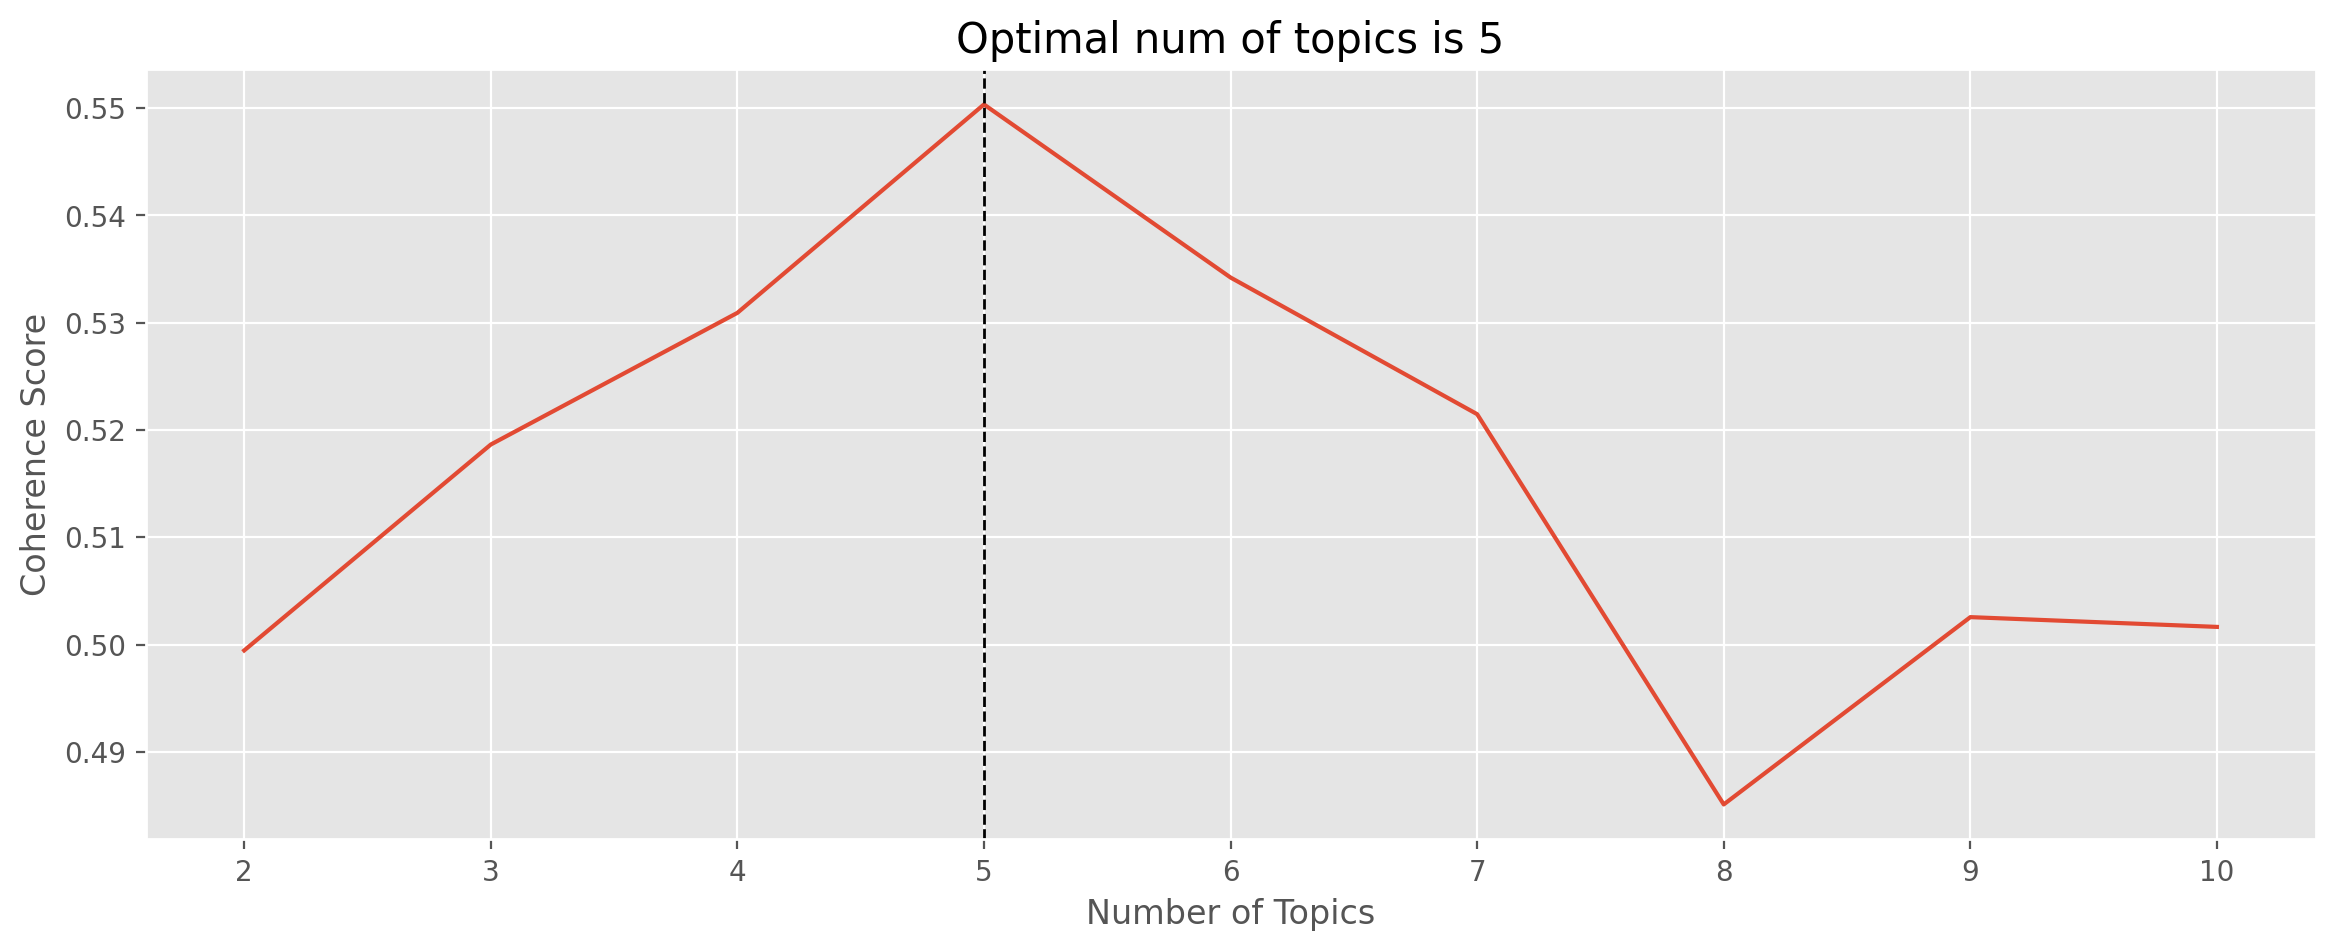

In [26]:
# Plot the coherence scores
plt.figure(figsize=(14, 5), dpi=200)
plt.plot(topics_range, coherence_scores)
plt.axvline(x=optimal_num_topics, linestyle='--', color='black', linewidth=1)
plt.xticks(range(2, 11, 1))
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title(f'Optimal num of topics is {optimal_num_topics}', size=15)
plt.show()

**Note**: Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

### **4.3 LDA Model Training**

In [27]:
# train LDA model
start_time = time.time()
lda_model = LdaModel(corpus=corpus,
                     num_topics=optimal_num_topics,
                     id2word=dictionary,
                     random_state=42,
                     passes=20)
end_time = time.time()
print(f'Time taken for model training: {end_time - start_time:.2f} seconds')

Time taken for model training: 92.16 seconds


In [55]:
# compute coherence score
untuned_coherence_model = CoherenceModel(model=lda_model, texts=df4['tokens'],
                                 dictionary=dictionary, coherence='c_v')
untuned_coherence_score = untuned_coherence_model.get_coherence()

# calculate perplexity
untuned_perplexity = lda_model.log_perplexity(corpus)
untuned_perplexity_value = np.exp(-untuned_perplexity)

# print output
print(f'Coherence score: {untuned_coherence_score:.4f}')
print(f'Perplexity: {untuned_perplexity_value:.4f}')

Coherence score: 0.5503
Perplexity: 1345.5950


### **4.4 Hyperparameter Tuning**
Reference of [parameters](https://radimrehurek.com/gensim/models/ldamodel.html)

In [35]:
param_grid = {
    'alpha': ['auto', 0.01, 0.1, 1.0],
    'iterations': [100, 200]
}

grid = ParameterGrid(param_grid)

In [36]:
best_coherence = -1
best_params = {}

for params in grid:
    start_time = time.time()
    # train the LDA model
    tuned_lda_model = LdaModel(corpus=corpus,
                         num_topics=optimal_num_topics,
                         id2word=dictionary,
                         alpha=params['alpha'],
                         passes=20,
                         iterations=params['iterations'],
                         random_state=42)
    # calculate coherence score
    coherence_model = CoherenceModel(model=tuned_lda_model, texts=df4['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Params: {params}, coherence score: {coherence_score:.4f}, TT: {elapsed_time:.2f} seconds")

    # update the best score and parameters
    if coherence_score > best_coherence:
        best_coherence = coherence_score
        best_params = params

print(f"Best Coherence Score: {best_coherence:.4f} with params: {best_params}")

Params: {'alpha': 'auto', 'iterations': 100}, coherence score: 0.5015, TT: 83.42 seconds
Params: {'alpha': 'auto', 'iterations': 200}, coherence score: 0.5035, TT: 82.41 seconds
Params: {'alpha': 0.01, 'iterations': 100}, coherence score: 0.5308, TT: 99.43 seconds
Params: {'alpha': 0.01, 'iterations': 200}, coherence score: 0.5465, TT: 100.25 seconds
Params: {'alpha': 0.1, 'iterations': 100}, coherence score: 0.5358, TT: 98.38 seconds
Params: {'alpha': 0.1, 'iterations': 200}, coherence score: 0.5340, TT: 99.77 seconds
Params: {'alpha': 1.0, 'iterations': 100}, coherence score: 0.5616, TT: 81.11 seconds
Params: {'alpha': 1.0, 'iterations': 200}, coherence score: 0.5616, TT: 89.77 seconds
Best Coherence Score: 0.5616 with params: {'alpha': 1.0, 'iterations': 100}


In [37]:
# train LDA model
start_time = time.time()
tuned_lda_model = LdaModel(corpus=corpus,
                     num_topics=optimal_num_topics,
                     id2word=dictionary,
                     random_state=42,
                     alpha=1.0,
                     iterations=100,
                     passes=20)
end_time = time.time()
print(f'Time taken for model training: {end_time - start_time:.2f} seconds')

Time taken for model training: 77.34 seconds


In [56]:
# compute coherence score
tuned_coherence_model = CoherenceModel(model=tuned_lda_model, texts=df4['tokens'],
                                 dictionary=dictionary, coherence='c_v')
tuned_coherence_score = tuned_coherence_model.get_coherence()

# calculate perplexity
tuned_perplexity = tuned_lda_model.log_perplexity(corpus)
tuned_perplexity_value = np.exp(-tuned_perplexity)

# print output
print(f'Coherence score: {tuned_coherence_score:.4f}')
print(f'Perplexity: {tuned_perplexity_value:.4f}')

Coherence score: 0.5616
Perplexity: 1242.3516


### **4.5 Evaluation and Explanation**

#### **3.5.1 Model Comparison**

In [67]:
# model comparison
pd.DataFrame({
    'Metric': ['UntunedCoherenceScore', 'UntunedPerplexity', 'TunedCoherenceScore', 'TunedPerplexity'],
    'Score': [untuned_coherence_score, untuned_perplexity_value, tuned_coherence_score, tuned_perplexity_value],
}).round(2)

Metric    Score
0  UntunedCoherenceScore     0.55
1      UntunedPerplexity  1345.60
2    TunedCoherenceScore     0.56
3        TunedPerplexity  1242.35

#### **4.5.2 Topic Extraction**

In [68]:
# display the top 10 words for each topic
for idx, topic in tuned_lda_model.show_topics(num_topics=5, num_words=10, formatted=False):
    print(f"Topic {idx}: {[word for word, _ in topic]}")

Topic 0: ['gopay', 'aplikasi', 'pake', 'gak', 'ribet', 'gojek', 'pembayaran', 'pakai', 'fitur', 'akun']
Topic 1: ['mantap', 'ok', 'good', 'semoga', 'apk', 'keren', 'oke', 'app', 'pokoknya', 'sukses']
Topic 2: ['ga', 'top', 'saldo', 'udah', 'pulsa', 'uang', 'beli', 'masuk', 'up', 'transfer']
Topic 3: ['__num__', 'bayar', 'ya', 'kasih', 'kota', 'bintang', 'coba', 'nih', 'tf', 'mempermudah']
Topic 4: ['bagus', 'mudah', 'membantu', 'banget', 'transaksi', 'aplikasinya', 'transfer', 'cepat', 'gratis', 'memudahkan']


In [69]:
pd.options.display.max_colwidth=None

# extract the topics and their word distributions 
topics_data = tuned_lda_model.show_topics(formatted=False)

# prepare a list to store formatted topics
formatted_topics = []
for idx, topic in topics_data:
    formatted_topic = ', '.join([f"({word}, {weight:.2f})" for word, weight in topic])
    formatted_topics.append((idx, formatted_topic))

# create a df
topics_df = pd.DataFrame(formatted_topics, columns=['n_topic', 'top_words'])
display(topics_df)

n_topic  \
0        0   
1        1   
2        2   
3        3   
4        4   

                                                                                                                                                                     top_words  
0                     (gopay, 0.17), (aplikasi, 0.13), (pake, 0.03), (gak, 0.03), (ribet, 0.03), (gojek, 0.02), (pembayaran, 0.02), (pakai, 0.02), (fitur, 0.01), (akun, 0.01)  
1                             (mantap, 0.16), (ok, 0.07), (good, 0.05), (semoga, 0.05), (apk, 0.05), (keren, 0.05), (oke, 0.03), (app, 0.02), (pokoknya, 0.02), (sukses, 0.02)  
2                                 (ga, 0.04), (top, 0.03), (saldo, 0.02), (udah, 0.02), (pulsa, 0.02), (uang, 0.02), (beli, 0.02), (masuk, 0.02), (up, 0.02), (transfer, 0.02)  
3                         (__num__, 0.06), (bayar, 0.03), (ya, 0.03), (kasih, 0.03), (kota, 0.02), (bintang, 0.02), (coba, 0.02), (nih, 0.01), (tf, 0.01), (mempermudah, 0.01)  
4  (bagus, 0.10), (mudah, 0.08), (membantu, 0.07), (banget, 0.06), (transaksi, 0.04), (aplikasinya, 0.04), (transfer, 0.03), (cepat, 0.03), (gratis, 0.02), (memudahkan, 0.02)

- **Topic 0**: This topic seems to focus on the Gopay application. Words like "gopay," "aplikasi," and "pembayaran" suggest that users discuss features and functionalities related to payment services. Words like "ribet" (complicated) imply user challenges.
- **Topic 1**: This topic is characterized by positive feedback about the app. Words like "mantap" (great) and "keren" (cool) reflect user satisfaction. "Semoga" (hopefully) may indicate anticipation for future improvements or features.
- **Topic 2**: This topic appears to revolve around financial transactions. Keywords like "saldo" (balance), "uang" (money), and "transfer" suggest discussions related to managing money and transactions within the app.
- **Topic 3**: This topic appears to revolve around financial transactions. Keywords like "saldo" (balance), "uang" (money), and "transfer" suggest discussions related to managing money and transactions within the app.
- **Topic 4**: This topic highlights user benefits and ease of use. Terms like "bagus" (good), "mudah" (easy), and "gratis" (free) suggest that users find the app useful and beneficial for conducting transactions quickly and easily.

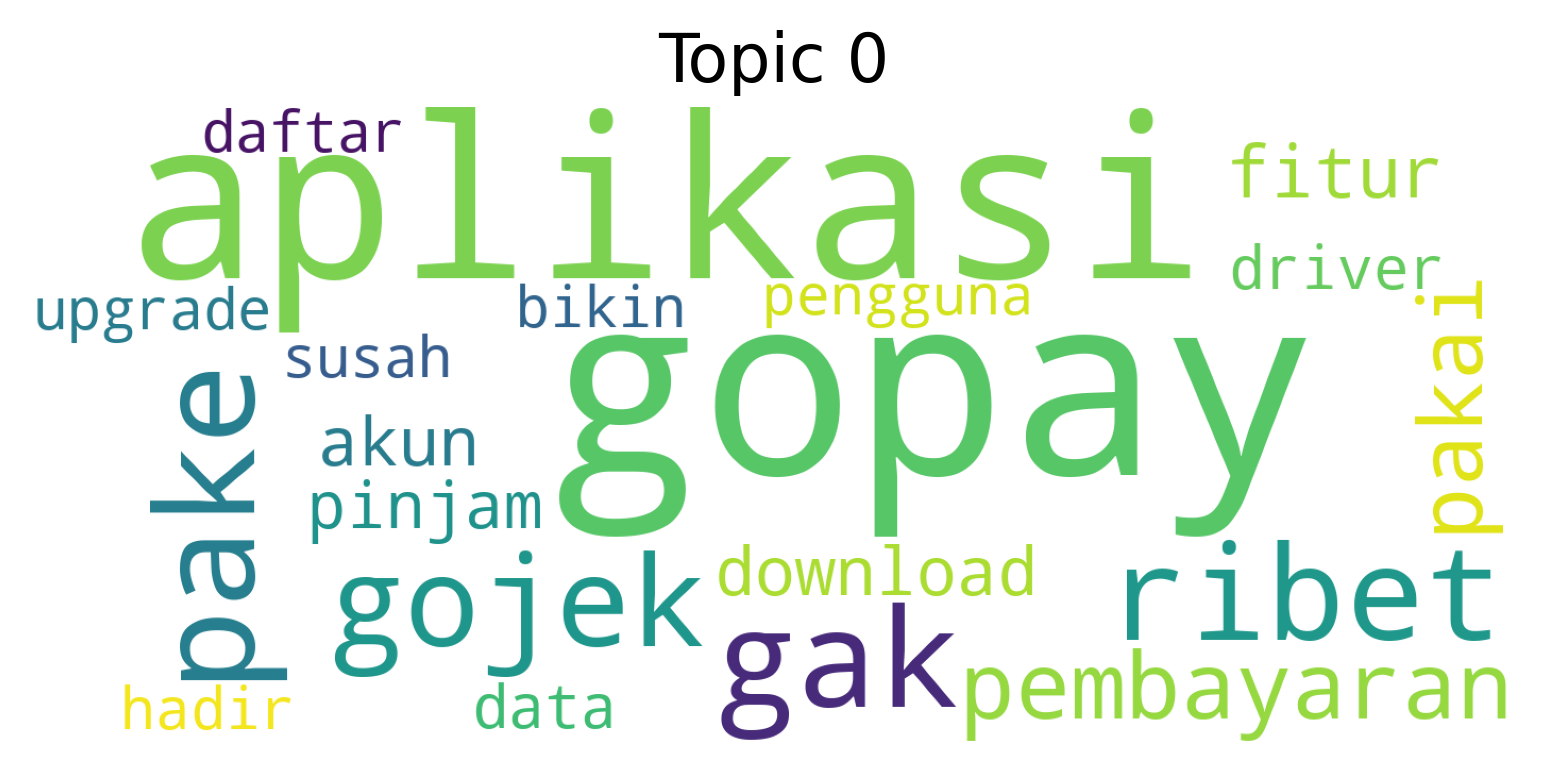

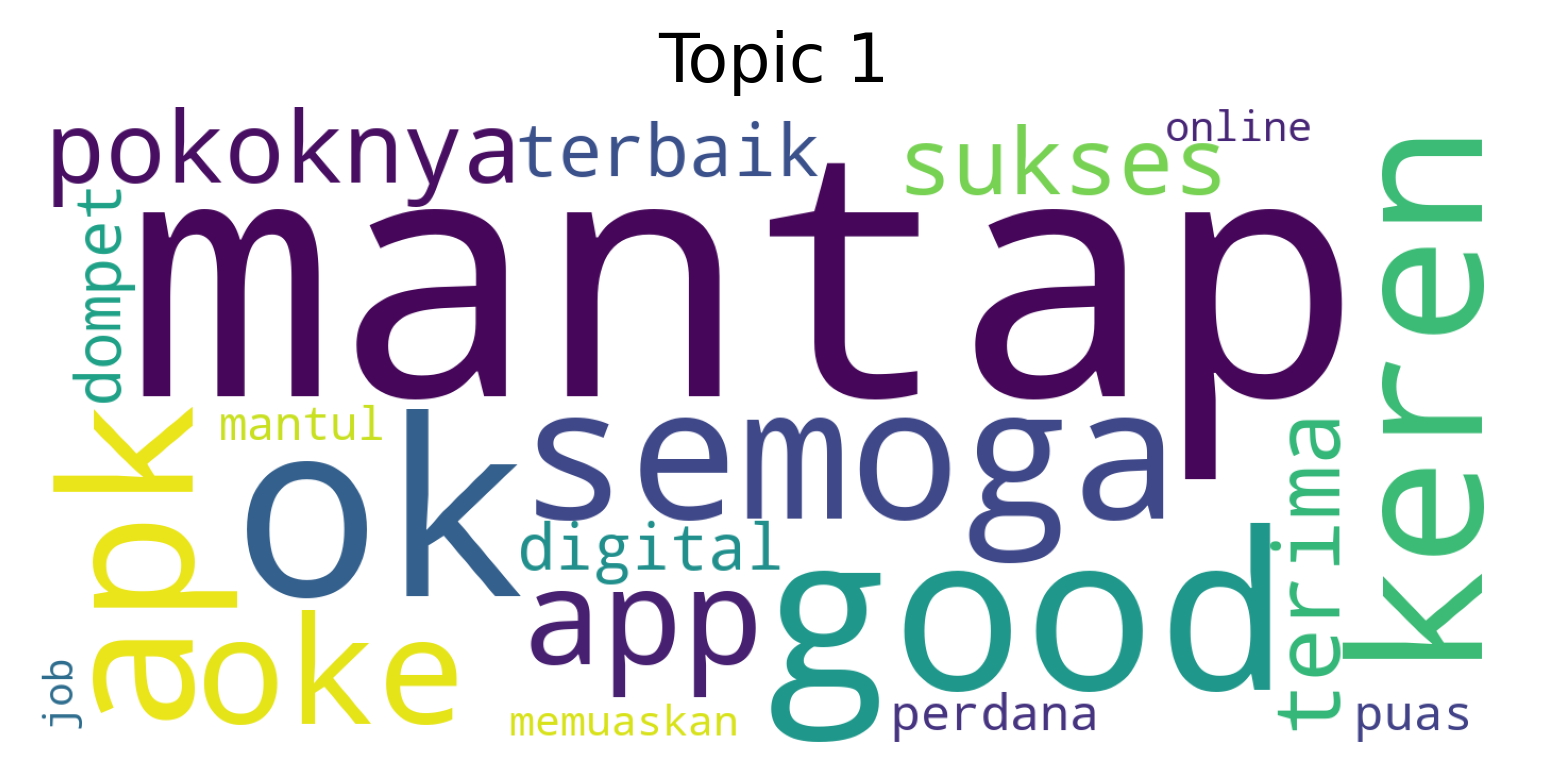

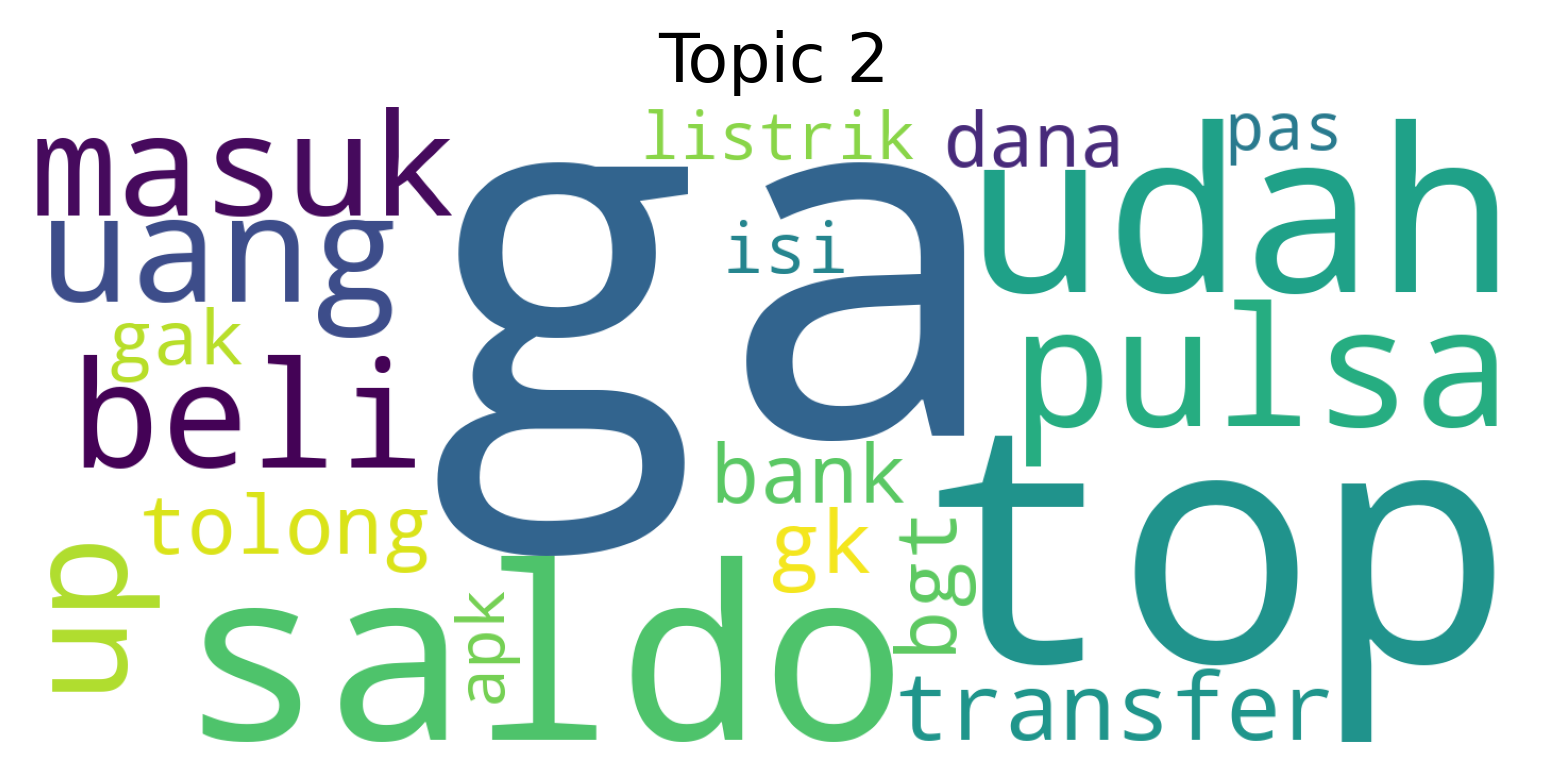

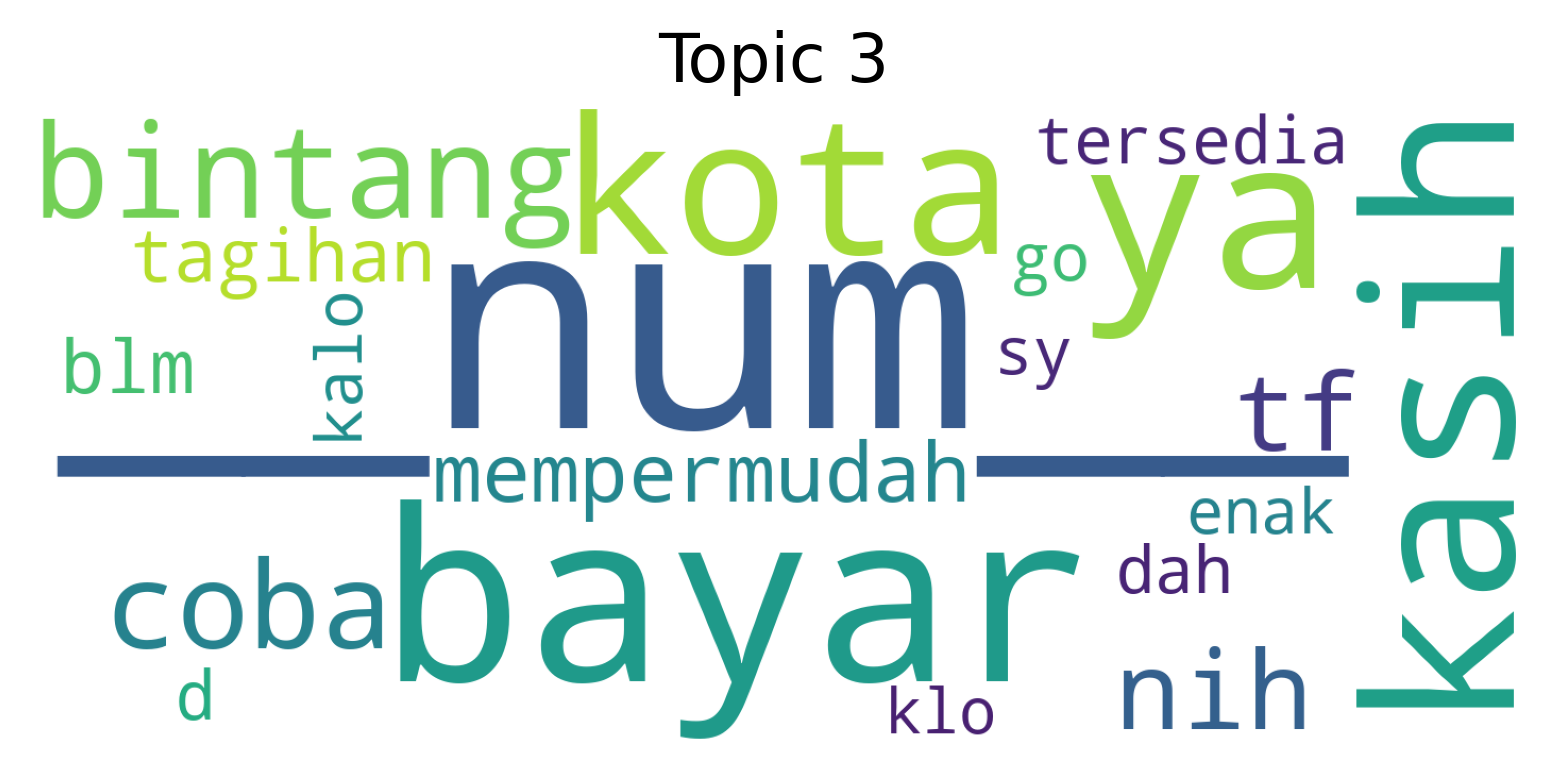

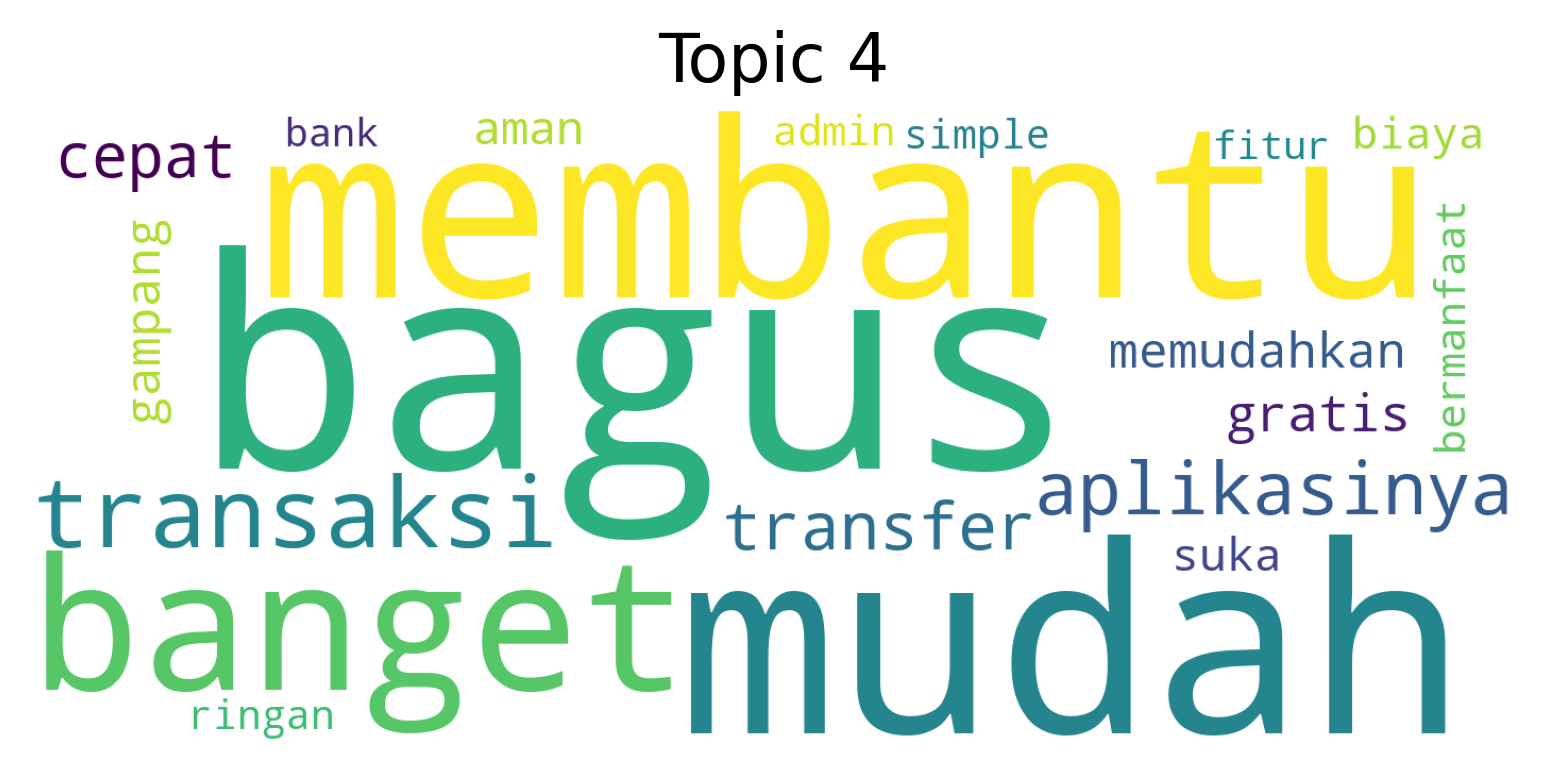

In [89]:
# generate word clouds for each topic
for idx in range(tuned_lda_model.num_topics):
    plt.figure(dpi=300)  # Increased DPI
    wordcloud = WordCloud(width=1400, height=600, background_color='white')\
                .fit_words(dict(tuned_lda_model.show_topic(idx, topn=20)))

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Topic {idx}', size=16)

    plt.show()

#### **4.5.3 Topic Distribution**

In [109]:
# init topics with default value (-1 for unclassified)
df4['topic'] = -1

# loop over each document and assign the most probable topic
for i, doc_bow in enumerate(corpus):
    if doc_bow:  
        topic_assignment = tuned_lda_model.get_document_topics(doc_bow)
        if topic_assignment:
            df4.at[i, 'topic'] = max(topic_assignment, key=lambda x: x[1])[0]

display(df4.head())

userName  \
0  Pengguna Google   
1  Pengguna Google   
2  Pengguna Google   
3  Pengguna Google   
4  Pengguna Google   

                                                           content  score  \
0                                                           Mantap      5   
1                                        Bagus dan mudah digunakan      5   
2                                                             Good      5   
3  Sangat membantu orang menengah mantap semoga sukses terus gopay      5   
4                                              Ga ribet .. Sukaaaa      5   

   thumbsUpCount reviewCreatedVersion                   at  \
0              0               1.24.1  2024-07-07 16:58:06   
1              0               1.24.1  2024-07-07 16:57:08   
2              0               1.24.1  2024-07-07 16:52:38   
3              0               1.24.1  2024-07-07 16:52:36   
4              0               1.24.1  2024-07-07 16:52:09   

                                                       tokens  topic  
0                                                    [mantap]      1  
1                                              [bagus, mudah]      4  
2                                                      [good]      1  
3  [membantu, orang, menengah, mantap, semoga, sukses, gopay]      1  
4                                        [ga, ribet, sukaaaa]      0

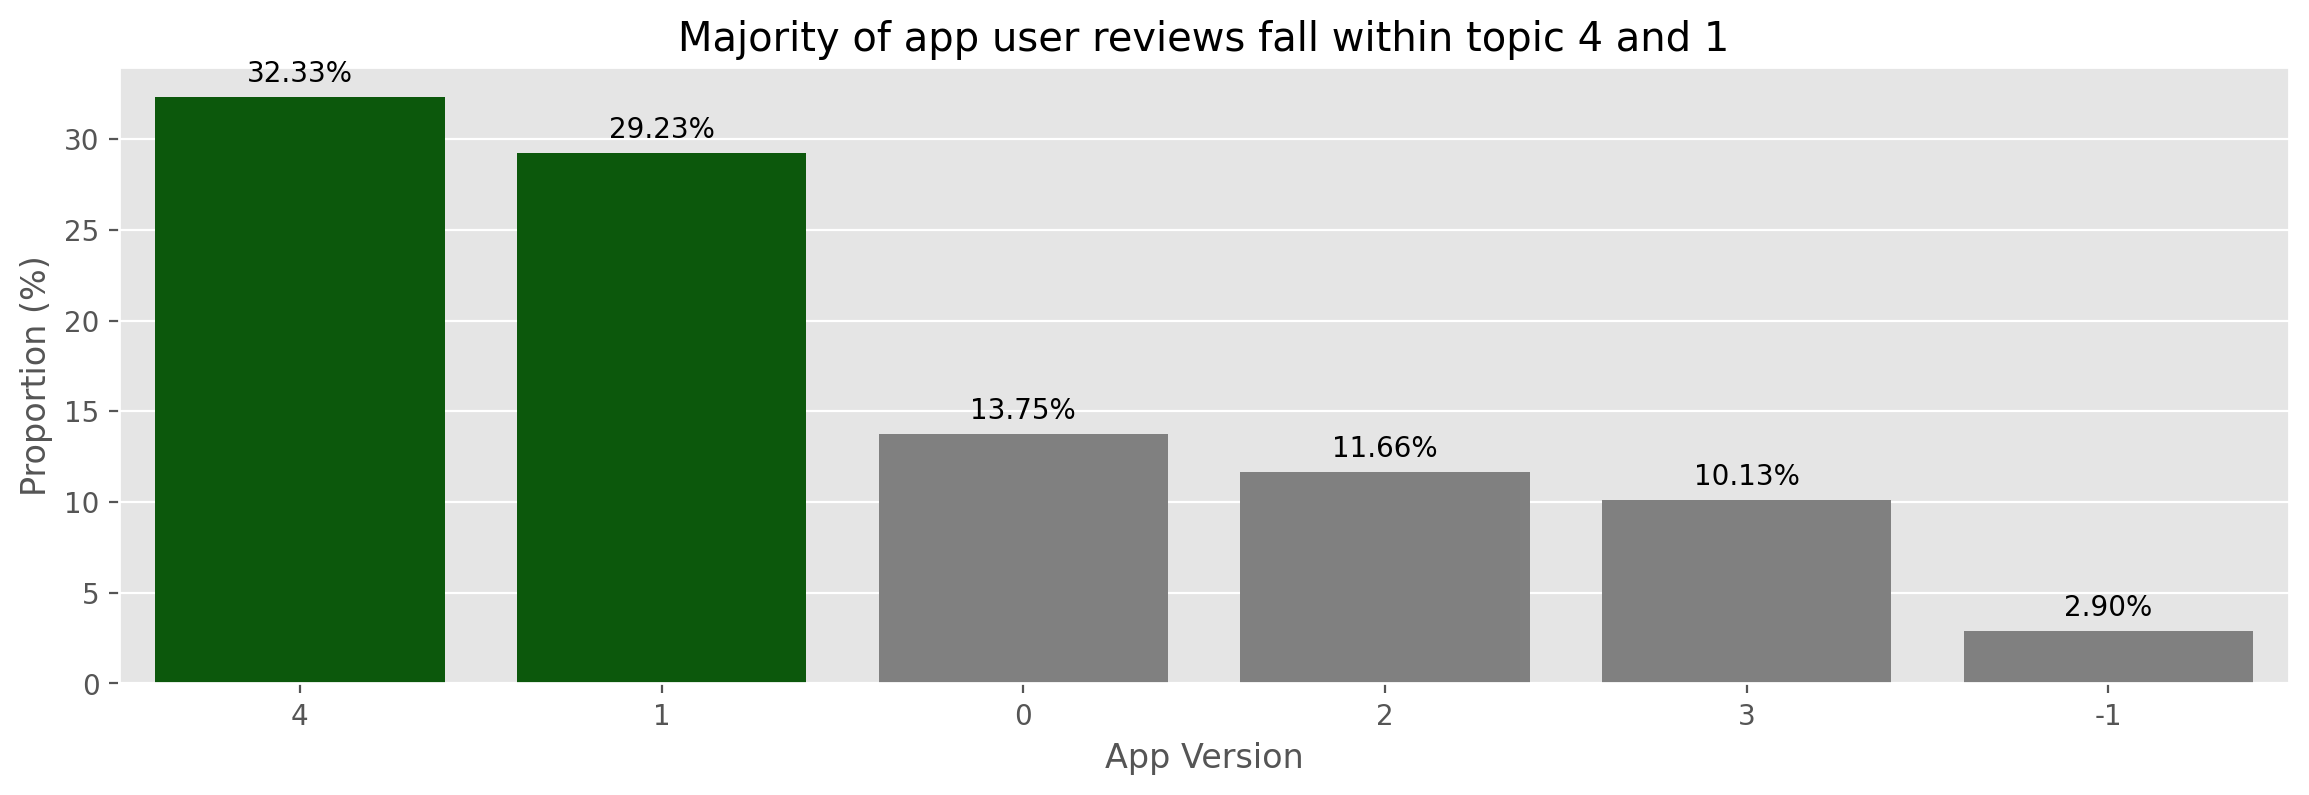

In [85]:
# prepare data
topic_proportion = (df4['topic'].value_counts(normalize=True)*100).reset_index().round(2)
topic_proportion['topic'] = topic_proportion['topic'].astype(str)
topic_proportion = topic_proportion.sort_values(by='proportion', ascending=False)

# set figure size
plt.figure(figsize=(14, 4), dpi=200)

# highlight topic 1 and 4
highlight_colors = ['darkgreen' if topic in ['1', '4'] else 'grey' for topic in topic_proportion['topic']]

# make bar chart
sns.barplot(y='proportion', x='topic', data=topic_proportion, hue='topic',
            palette=highlight_colors)

for index, row in topic_proportion.iterrows():
    plt.text(row.name, row['proportion'] + 0.5, f'{row["proportion"]:.2f}%', 
             ha='center', va='bottom', fontsize=10)

plt.title('Majority of app user reviews fall within topic 4 and 1')
plt.xlabel('App Version')
plt.ylabel('Proportion (%)')
plt.show()

In [121]:
# Locate unclassified instances
unclassified_ins = df4[df4['topic'] == -1].copy()  
unclassified_ins.loc[:, 'review_len'] = unclassified_ins['content'].str.split().str.len()  
print(f"Total unclassified instances: {len(unclassified_ins)}")
unclassified_ins.loc[:, ['userName', 'content', 'review_len', 'score', 'tokens', 'topic']].head()

Total unclassified instances: 3571


userName                                               content  \
119682  Pengguna Google                                           Mantaap....   
119683  Pengguna Google                                                Mantap   
119684  Pengguna Google  Mantap pembayaran lebih mudah dan cepat ga pke ribet   
119685  Pengguna Google                                               Ok dulu   
119686  Pengguna Google             Keterangan maaf kami belum hadir dikotamu   

        review_len  score                                              tokens  \
119682           1      5                                           [mantaap]   
119683           1      5                                            [mantap]   
119684           9      5  [mantap, pembayaran, mudah, cepat, ga, pke, ribet]   
119685           2      5                                                [ok]   
119686           6      3                 [keterangan, maaf, hadir, dikotamu]   

        topic  
119682     -1  
119683     -1  
119684     -1  
119685     -1  
119686     -1

**Question**: Why are 2.9% of documents unclassified to any topics? This can happen due to a number of reasons such as topic outliers (significantly different content from the rest), short document length (not enough information to infer the topic group), topic overlap (mic of terms from different topics), and model limitation (not the best model).

In [127]:
df4['review_len'] = df4['content'].str.split().str.len()

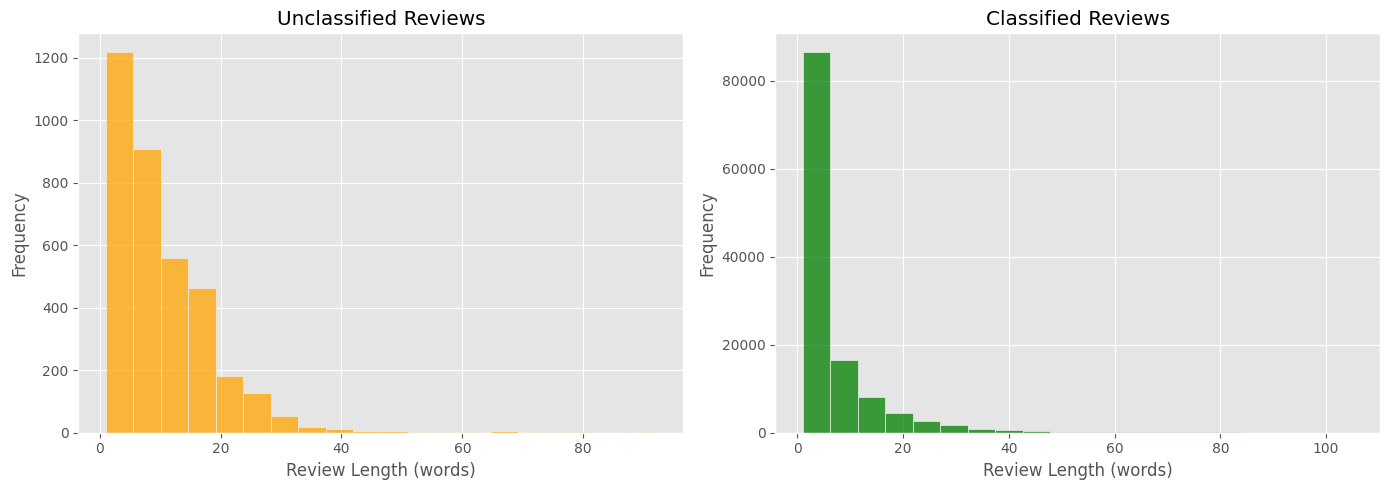

In [128]:
# Set up the figure with two subplots
plt.figure(figsize=(14, 5))

# First subplot for unclassified reviews
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(unclassified_ins['review_len'], bins=20, color='orange', kde=False)
plt.title('Unclassified Reviews')
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')

# Second subplot for classified reviews
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df4['review_len'], bins=20, color='green', kde=False)
plt.title('Classified Reviews')
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()


In [97]:
# prepare data
topic_distribution = np.zeros((len(df4), tuned_lda_model.num_topics))
for i, item in enumerate(corpus):
    if item:
        topic_info = lda_model.get_document_topics(item)
        for topic_id, prob in topic_info:
            topic_distribution[i, topic_id] = prob

topic_df = pd.DataFrame(topic_distribution,
                        columns=[f'Topic {i}' for i in range(tuned_lda_model.num_topics)])

topic_df.head(10)

Topic 0   Topic 1   Topic 2   Topic 3   Topic 4
0  0.100000  0.100000  0.100000  0.600000  0.100000
1  0.066667  0.066667  0.066667  0.066667  0.733333
2  0.100000  0.100000  0.599998  0.100000  0.100000
3  0.025339  0.774360  0.025181  0.150047  0.025073
4  0.454740  0.050135  0.050546  0.050137  0.394442
5  0.100000  0.599999  0.100000  0.100000  0.100000
6  0.548102  0.050619  0.050379  0.300514  0.050387
7  0.050000  0.050000  0.050000  0.800000  0.050000
8  0.238670  0.440805  0.040056  0.040057  0.240412
9  0.100259  0.100260  0.100260  0.100264  0.598957

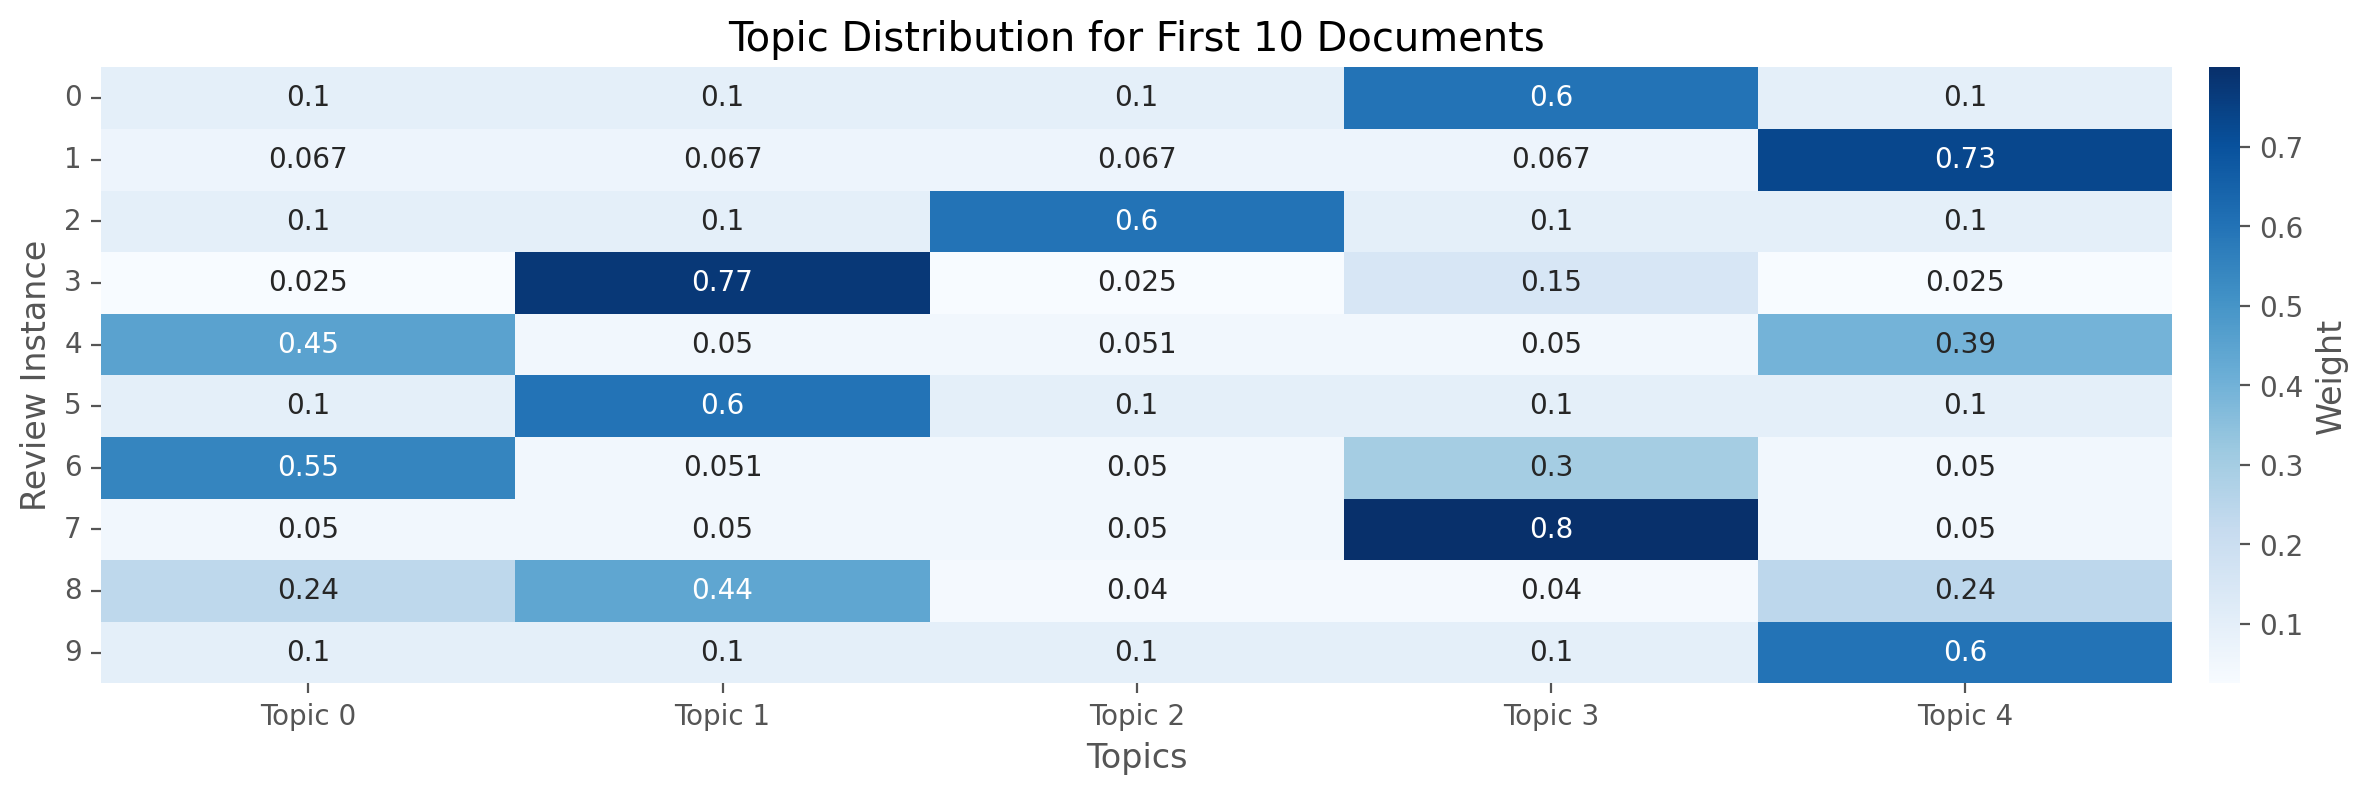

In [47]:
# visualize topic distribution for top-10 instance
plt.figure(figsize=(16, 4), dpi=200)
sns.heatmap(topic_df.iloc[:10], cmap='Blues', annot=True, cbar_kws={'label': 'Weight', 'pad': 0.015})
plt.title('Topic Distribution for First 10 Documents')
plt.ylabel('Review Instance')
plt.xlabel('Topics')
plt.yticks(rotation=0)
plt.show()

**Note**: Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

#### **4.1.4 Visualizing Topic Clusters**

In [99]:
# Apply PCA to retain 95% of the variance
start_time = time.time()
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(topic_distribution)
end_time = time.time()
print(f'Time taking for training PCA model: {start_time - end_time:.2f} seconds')

Time taking for training PCA model: -0.04 seconds


In [108]:
print(f'Number of components selected: {pca.n_components_}')
print('\nSnippet of topic distribution after PCA:')
print(reduced_data[1,:])

Number of components selected: 4

Snippet of topic distribution after PCA:
[ 0.52206957 -0.14681386 -0.02264583  0.02261573]


t-SNE is computationally expensive and sensitive to noise. Reducing the dimensionality with PCA beforehand helps reduce computation time and improve results.

In [68]:
# Then apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(reduced_data)

- PCA is great for quickly reducing dimensionality and capturing global structure, but it might miss finer local clusters.
- t-SNE excels at showing distinct clusters but is computationally expensive and better for final visualization in 2D or 3D.

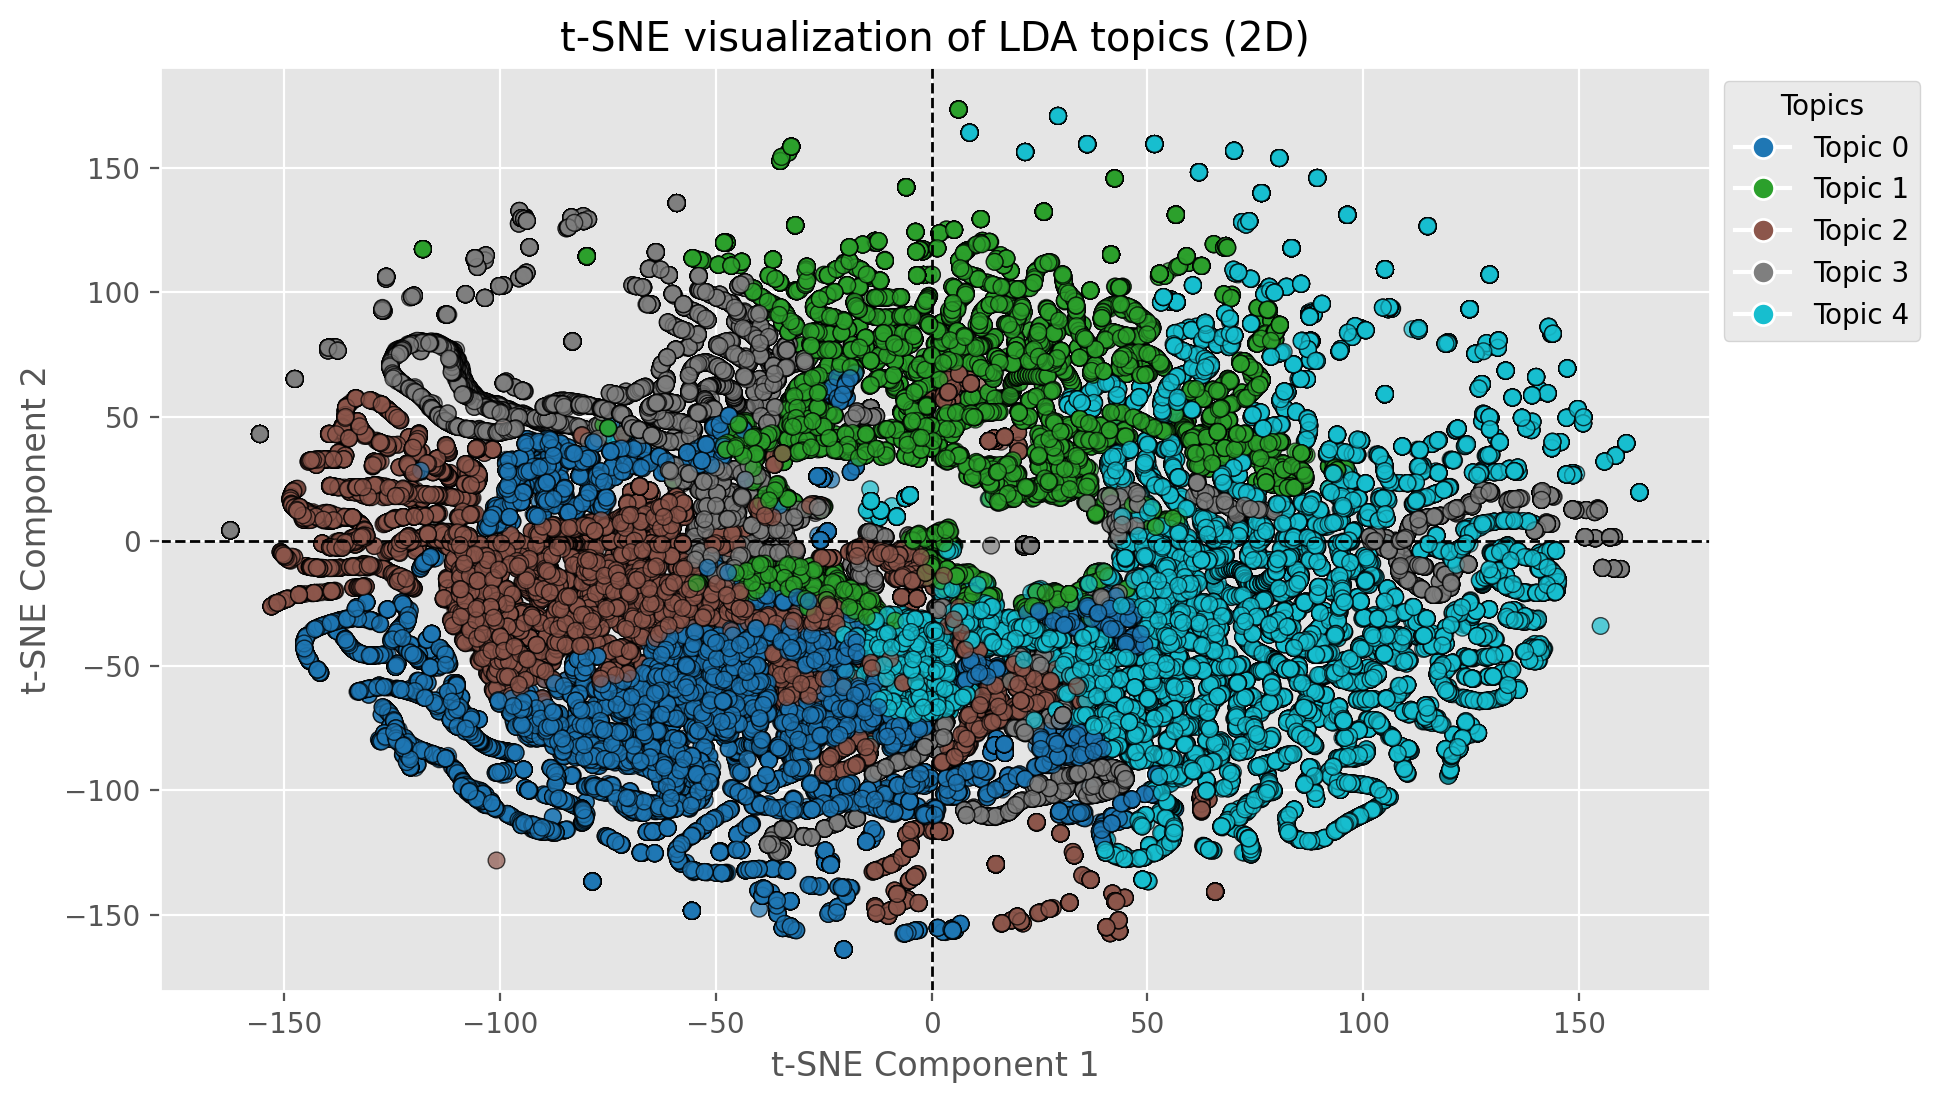

In [81]:
# Filter the topic column to match the reduced data
filtered_topics = df4['topic'].iloc[:len(tsne_results)]
# Get unique topics and sort them
unique_topics = np.sort(filtered_topics.unique())

# Plotting the 2D t-SNE results
plt.figure(figsize=(10, 6), dpi=200)
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=filtered_topics, cmap='tab10', alpha=0.7, edgecolor='k')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.axvline(0, color='k', linestyle='--', linewidth=1)

# Add custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=scatter.cmap(scatter.norm(topic)),
                      markersize=8, label=f'Topic {int(topic)}') for topic in unique_topics]

plt.legend(handles=handles, title="Topics", bbox_to_anchor=(1, 1), loc='upper left')
plt.title('t-SNE visualization of LDA topics (2D)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.show()


The plot clearly shows the formation of distinct clusters, suggesting that the topic model effectively groups documents with similar thematic content.
The clusters are relatively well-separated, indicating that the topics are reasonably distinct from one another.

Some overlap between clusters suggests that there are shared characteristics or similarities among certain topics, which is common in real-world data.
There are a few points that appear to be outliers, located outside the main clusters. These might represent documents that do not fit cleanly into any of the defined topics or might be artifacts of the t-SNE algorithm.

In [110]:
vis = gensimvis.prepare(tuned_lda_model, corpus, dictionary)
pyLDAvis.display(vis)

pelajari t-SNE untuk apa dan bagaimana cara kerjanya. Apa bedanya dengan PCA

In [111]:
display((df4['topic'].value_counts(normalize=True)*100).to_frame().round(2).sort_index().transpose())
display((df4['topic'].value_counts()).to_frame().round(2).sort_index().transpose())

topic        -1      0      1      2      3      4
proportion  2.9  13.74  29.24  11.66  10.13  32.33

topic    -1      0      1      2      3      4
count  3571  16936  36044  14372  12483  39847

In [ ]:
# compute coherence score
coherence_model = CoherenceModel(model=lda_model, texts=df4['tokens'],
                                 dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score:.4f}')

Coherence Score: 0.5373


The coherence score measures the degree of semantic similarity between high-scoring words in each topic. It ranges from 0 to 1, with higher scores indicating better topic quality. A score of 0.5373 suggests that the topics are moderately coherent. This means that the words in each topic are somewhat related and can collectively convey a clear theme or meaning.

Perplexity is a measure of how well the probability distribution predicted by the model aligns with the observed data. Lower perplexity indicates a better fit to the data.

In [ ]:
# palculate perplexity
perplexity = lda_model.log_perplexity(corpus)

# Convert log perplexity to perplexity
perplexity_value = np.exp(-perplexity)

print(f'Perplexity: {perplexity_value:.4f}')

Perplexity: 1340.5662


#### **4.1.5 Topic Distributions over Time**

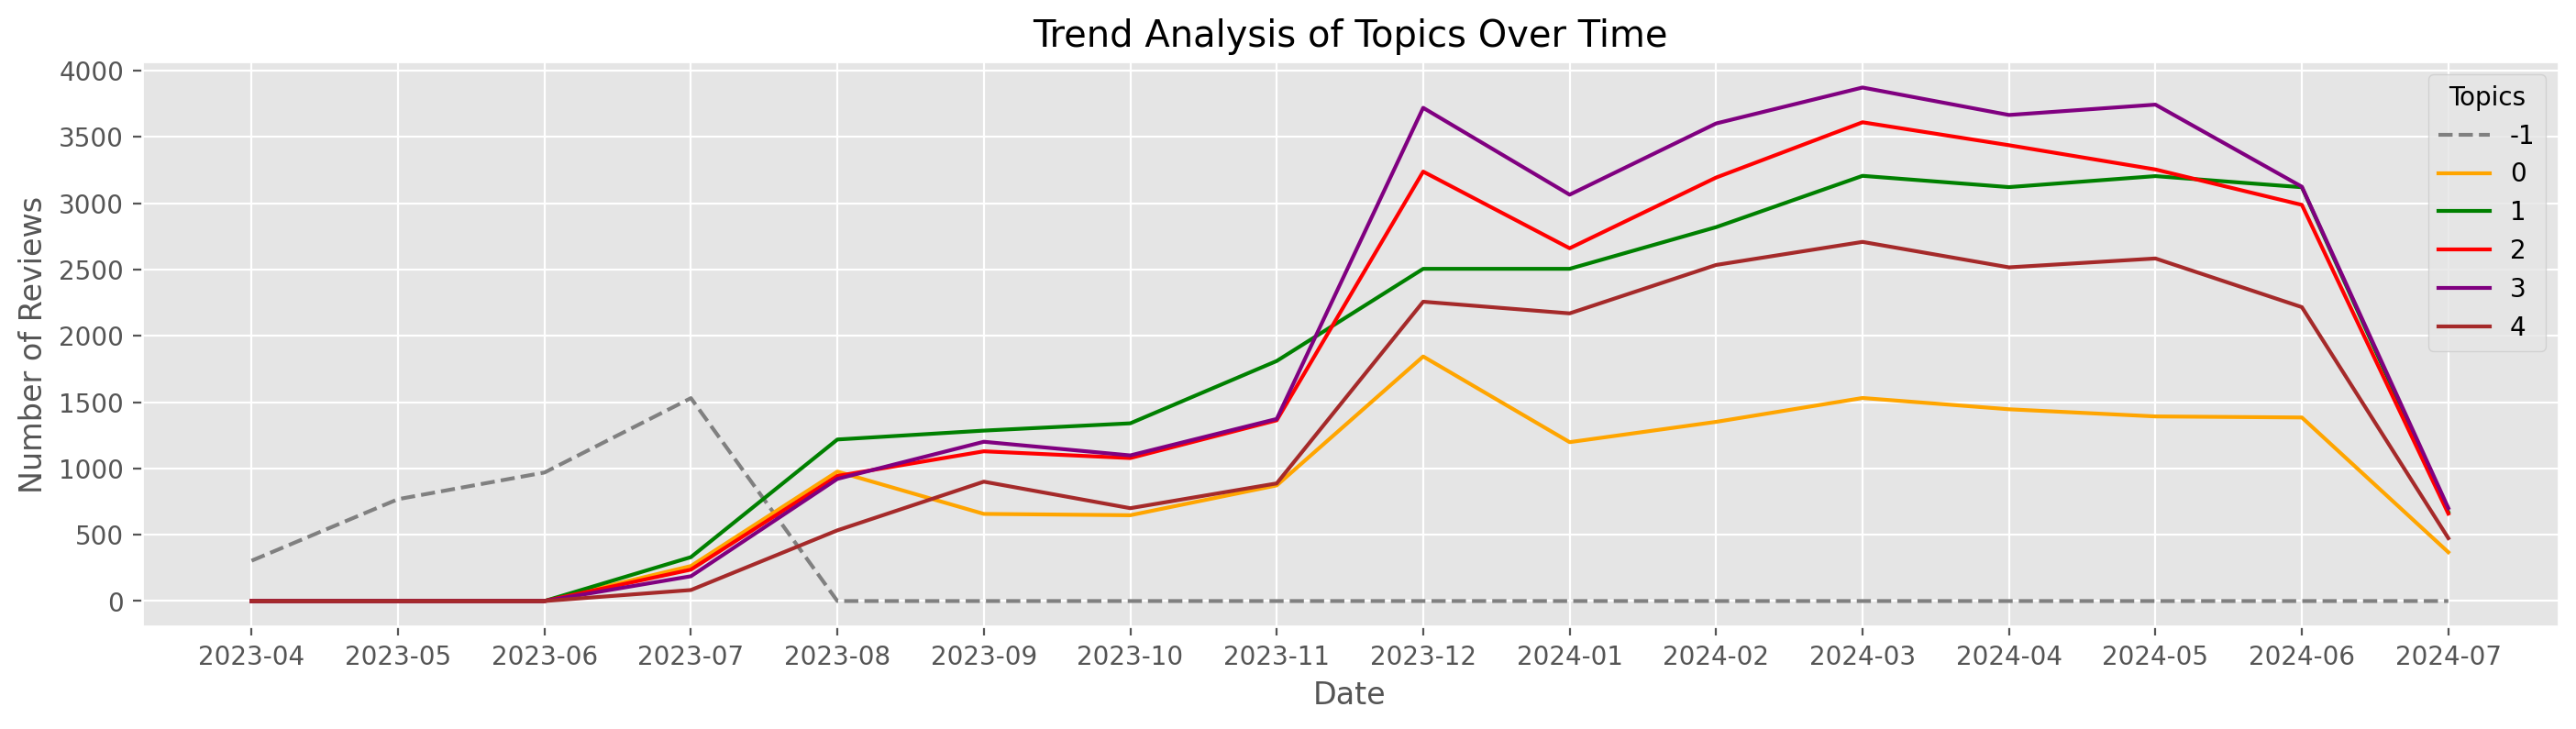

In [ ]:
# prepare data
df4['year_month'] = df4['at'].dt.to_period('M').astype(str)
topic_trends = df4.groupby(['year_month', 'topic']).size().unstack(fill_value=0)

# Plotting the trends
plt.figure(figsize=(17, 4), dpi=200)
custom_palette = ['grey', 'orange', 'green', 'red', 'purple', 'brown']
line_styles = ['--', '-', '-', '-', '-', '-']
for idx, topic in enumerate(topic_trends.columns):
    sns.lineplot(data=topic_trends[topic],
                 color=custom_palette[idx % len(custom_palette)],
                 linestyle=line_styles[idx % len(line_styles)],
                 label=topic)
plt.title('Trend Analysis of Topics Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Topics')
plt.grid(True)
plt.show()